## Import Libraries

In [163]:
import pandas as pd
import zipfile
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
os.getcwd()

'/Users/domenicospoto/Desktop/Sapienza/MScDataScience/FundamentalsofDataScienceandLaboratory/FinalProject/FDS-FinalProject'

In [2]:
# extract file with zipfile
zip_df = zipfile.ZipFile('walmart-recruiting-store-sales-forecasting.zip')
zip_df.extractall()
zip_df.close()

## Exploratory Data Analysis

### Part 1: Data cleaning

In [164]:
# cols: Store, Dept, Date, Weekly_Sales, IsHoliday
train = pd.read_csv('train.csv.zip', compression='zip')
# cols: Store, Dept, Date, IsHoliday
test = pd.read_csv('test.csv.zip', compression='zip')
# cols: Store, Date, Temperature, Fuel_Price, MarkDown1 - 5, CPI, Unemployment, IsHoliday
features = pd.read_csv('features.csv.zip', compression='zip')
# cols: Store, Type, Size
stores = pd.read_csv('stores.csv')
# cols: Id, Weekly_Sales
sample_submission = pd.read_csv('sampleSubmission.csv.zip', compression='zip')

In this section we print the information on "train", "features", "stores" and "test datasets.

In [165]:
print(pd.DataFrame(train.dtypes, columns=['Type']))
train

                 Type
Store           int64
Dept            int64
Date           object
Weekly_Sales  float64
IsHoliday        bool


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [166]:
print(pd.DataFrame(features.dtypes, columns=['Type']))
features.head()

                 Type
Store           int64
Date           object
Temperature   float64
Fuel_Price    float64
MarkDown1     float64
MarkDown2     float64
MarkDown3     float64
MarkDown4     float64
MarkDown5     float64
CPI           float64
Unemployment  float64
IsHoliday        bool


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [167]:
print(pd.DataFrame(stores.dtypes, columns=['Type']))
stores.head()

         Type
Store   int64
Type   object
Size    int64


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [168]:
print(pd.DataFrame(test.dtypes, columns=['Type']))
test

             Type
Store       int64
Dept        int64
Date       object
IsHoliday    bool


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


In [169]:
# shapes of files
print(train.shape)
print(test.shape)
print(features.shape)
print(stores.shape)
print(sample_submission.shape)

(421570, 5)
(115064, 4)
(8190, 12)
(45, 3)
(115064, 2)


As we can see, the column 'Date' in train, features and test is a string type of data. We can convert it to datetime.

In [170]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [171]:
print(pd.DataFrame({'type': [train['Date'].dtypes,features['Date'].dtypes,test['Date'].dtypes]}, 
                    index=['train', 'features', 'test']))

                    type
train     datetime64[ns]
features  datetime64[ns]
test      datetime64[ns]


Now, we can merge the datasets.

In [172]:
# merge the features with the stores dataset
new_features = pd.merge(features, stores, on=['Store'])
print(pd.DataFrame(new_features.dtypes, columns=['Type'])) # types of new dataframe
new_features.head()

                        Type
Store                  int64
Date          datetime64[ns]
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
IsHoliday               bool
Type                  object
Size                   int64


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [173]:
# merge the train with the new features dataset
df_train = pd.merge(train, new_features, on=['Store', 'Date', 'IsHoliday'])
print(pd.DataFrame(df_train.dtypes, columns=['Type'])) # types of new dataframe
df_train

                        Type
Store                  int64
Dept                   int64
Date          datetime64[ns]
Weekly_Sales         float64
IsHoliday               bool
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
Type                  object
Size                   int64


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


In [174]:
# merge the test with the new features dataset
df_test = pd.merge(test, new_features, on=['Store', 'Date', 'IsHoliday'])
print(pd.DataFrame(df_test.dtypes, columns=['Type'])) # types of new dataframe
df_test

                        Type
Store                  int64
Dept                   int64
Date          datetime64[ns]
IsHoliday               bool
Temperature          float64
Fuel_Price           float64
MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
CPI                  float64
Unemployment         float64
Type                  object
Size                   int64


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115060,45,94,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115061,45,95,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221
115062,45,97,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221


Here, we can check how many Nans values we have in the dataset.

In [175]:
# get all Nan values in train dataset and their percentages
df_nan = pd.concat([df_train.isna().sum(), round(df_train.isna().sum()/len(df_train)*100, 4)], axis=1)\
                .rename(columns={0: '# nan', 1: '% nan'}).sort_values(ascending=False, by=['% nan'])
df_nan

,# nan,% nan
MarkDown2,310322,73.6110
MarkDown4,286603,67.9847
MarkDown3,284479,67.4808
MarkDown1,270889,64.2572
MarkDown5,270138,64.0790
Store,0,0.0000
Dept,0,0.0000
Date,0,0.0000
Weekly_Sales,0,0.0000
IsHoliday,0,0.0000


The only columns with Nan values are the markdown ones with more than 60 % of them.

### Part 2: Holiday Analysis

In [176]:
# add columns to select week and year from date
df_train['week'] = df_train['Date'].dt.week
df_train['year'] = df_train['Date'].dt.year
df_test['week'] = df_test['Date'].dt.week
df_test['year'] = df_test['Date'].dt.year
# KEEPING THE COLUMN 'DATE', MAYBE WE CAN REMOVE IT AFTERWORDS

In [177]:
df_train_holiday = df_train[df_train['IsHoliday'] == True]
df_test_holiday = df_test[df_test['IsHoliday'] == True]
df_train_holiday

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,year
73,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
74,1,2,2010-02-12,44682.74,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
75,1,3,2010-02-12,10887.84,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
76,1,4,2010-02-12,35351.21,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
77,1,5,2010-02-12,29620.81,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421096,45,93,2012-09-07,3607.37,True,75.70,3.911,11024.45,12.8,52.63,1854.77,2055.7,191.577676,8.684,B,118221,36,2012
421097,45,94,2012-09-07,3938.63,True,75.70,3.911,11024.45,12.8,52.63,1854.77,2055.7,191.577676,8.684,B,118221,36,2012
421098,45,95,2012-09-07,52417.47,True,75.70,3.911,11024.45,12.8,52.63,1854.77,2055.7,191.577676,8.684,B,118221,36,2012
421099,45,97,2012-09-07,7426.19,True,75.70,3.911,11024.45,12.8,52.63,1854.77,2055.7,191.577676,8.684,B,118221,36,2012


We consider the fact that the Super Bowl happens five months after the Labour Day so on the 6th week of each year, the Labour Day happens on the first Monday of September (on the 36th week of each year), the Thanksgiving happens the fourth Thursday of November (on the 47th week of each year) and Christmas happens on the 25th day each year.

In [178]:
Year = []
Week = []
Data_type = []
Holiday = []
Day = []
for i in df_train_holiday['Date'].unique():
    Week.append(int(df_train_holiday.set_index('Date').loc[i, 'week'].unique()))
    Year.append(int(df_train_holiday.set_index('Date').loc[i, 'year'].unique()))
    Data_type.append('Train data')
    if df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 6:
        Holiday.append('Super Bowl')
    elif df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 36:
        Holiday.append('Labour Day')
    elif df_train_holiday.set_index('Date').loc[i, 'week'].unique() == 47:
        Holiday.append('Thanksgiving')
    else:
        Holiday.append('Christmas')

for i in df_test_holiday['Date'].unique():
    Week.append(int(df_test_holiday.set_index('Date').loc[i, 'week'].unique()))
    Year.append(int(df_test_holiday.set_index('Date').loc[i, 'year'].unique()))
    Data_type.append('Test data')
    if df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 6:
        Holiday.append('Super Bowl')
    elif df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 36:
        Holiday.append('Labour Day')
    elif df_test_holiday.set_index('Date').loc[i, 'week'].unique() == 47:
        Holiday.append('Thanksgiving')
    else:
        Holiday.append('Christmas')

table = pd.DataFrame({'Year': Year, 'Week': Week,
                  'Data_type': Data_type, 'Holiday': Holiday})
table

,Year,Week,Data_type,Holiday
0,2010,6,Train data,Super Bowl
1,2010,36,Train data,Labour Day
2,2010,47,Train data,Thanksgiving
3,2010,52,Train data,Christmas
4,2011,6,Train data,Super Bowl
5,2011,36,Train data,Labour Day
6,2011,47,Train data,Thanksgiving
7,2011,52,Train data,Christmas
8,2012,6,Train data,Super Bowl
9,2012,36,Train data,Labour Day


We can see that in the Test dataset there is no 'Labour Day', so this holiday is not relevant.

Here, we compute the Average Weekly Sales per Year and see if there are week holidays that we are not considering.

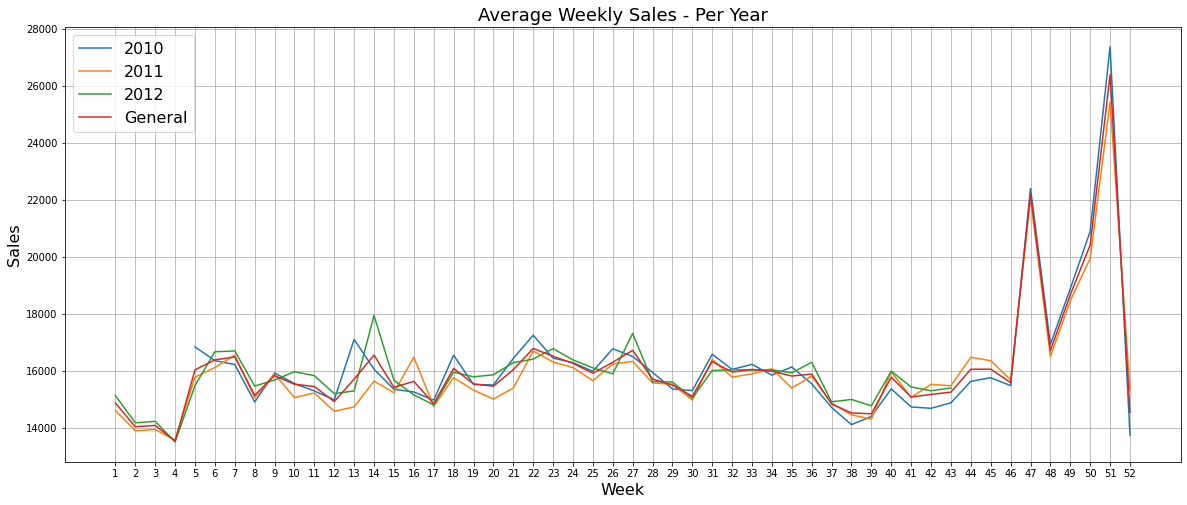

In [154]:
weekly_sales_2010 = df_train[df_train.year==2010]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_2011 = df_train[df_train.year==2011]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_2012 = df_train[df_train.year==2012]['Weekly_Sales'].groupby(df_train['week']).mean()
weekly_sales_general = df_train['Weekly_Sales'].groupby(df_train['week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
sns.lineplot(weekly_sales_general.index, weekly_sales_general.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012','General'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

We may see that there is a peak between the 13th and the 14th week each year and it is Easter Day.
    
    - In 2010 is in week 13
    - In 2011 is in week 16
    - In 2012 is in week 14
 
Now we can change the 'IsHoliday' feature to True.

In [157]:
df_train.loc[(df_train['year'] == 2010) & (df_train['week'] == 13), 'IsHoliday'] = True #2010
df_train.loc[(df_train['year'] == 2011) & (df_train['week'] == 16), 'IsHoliday'] = True #2011
df_train.loc[(df_train['year'] == 2012) & (df_train['week'] == 14), 'IsHoliday'] = True #2012

Here, we show the Mean and Median of the Weekly Sales for all the years together.

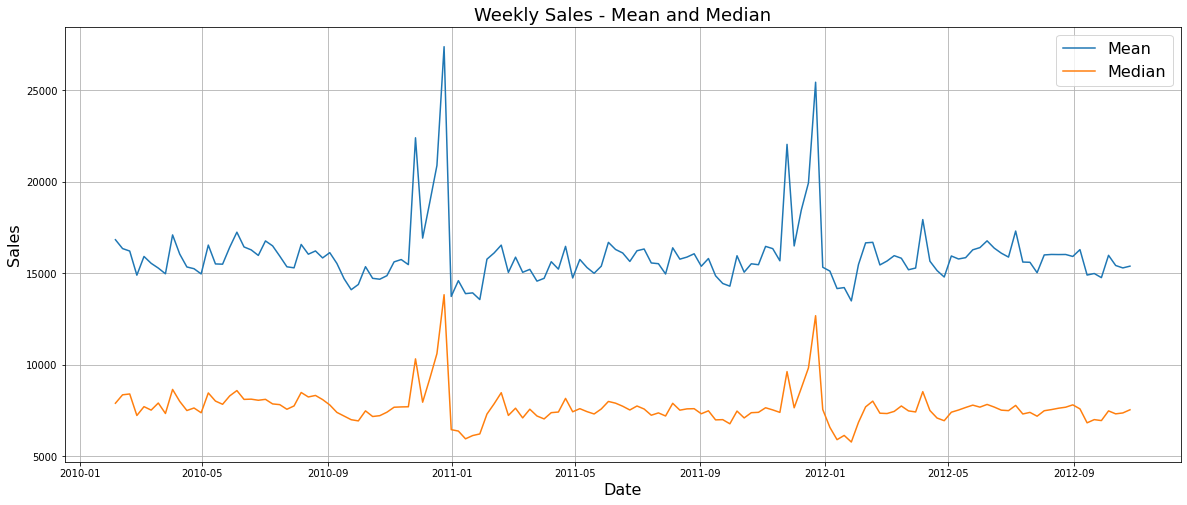

In [179]:
weekly_sales_mean = df_train['Weekly_Sales'].groupby(df_train['Date']).mean()
weekly_sales_median = df_train['Weekly_Sales'].groupby(df_train['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

From this graph we can see that there are some stores/depts that sell much more items than the others because the mean is higher compared to the median. Moreover, it seems there is a sort of cyclicality during the last two months of each year.

### Part 3: Weekly Sales Analsysis

We show the Average Sales per Store.

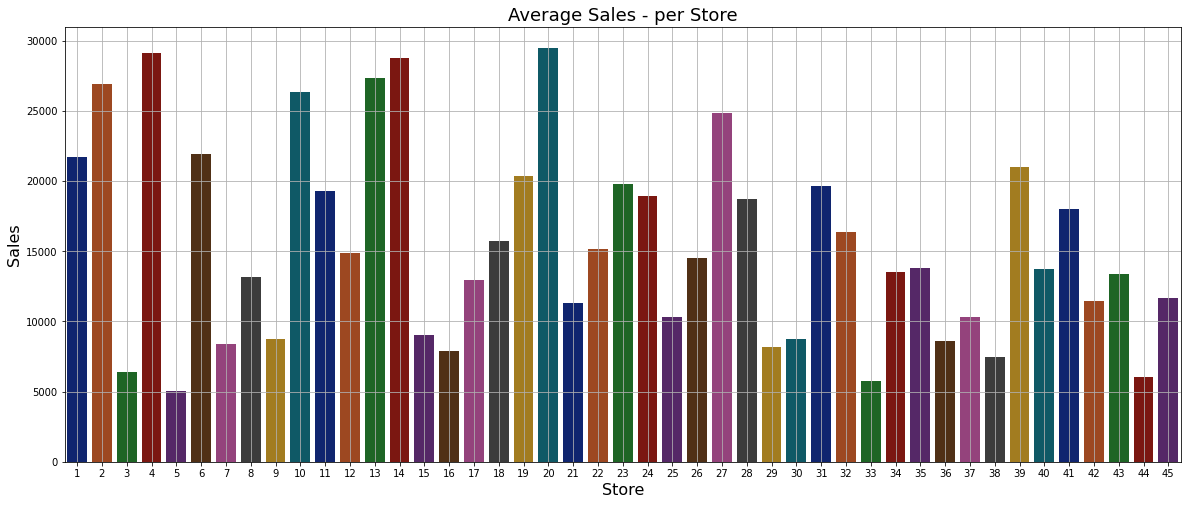

In [193]:
weekly_sales_store = df_train['Weekly_Sales'].groupby(df_train['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales_store.index, weekly_sales_store.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

The graph confirms there are some stores that have an average sales higher than others.

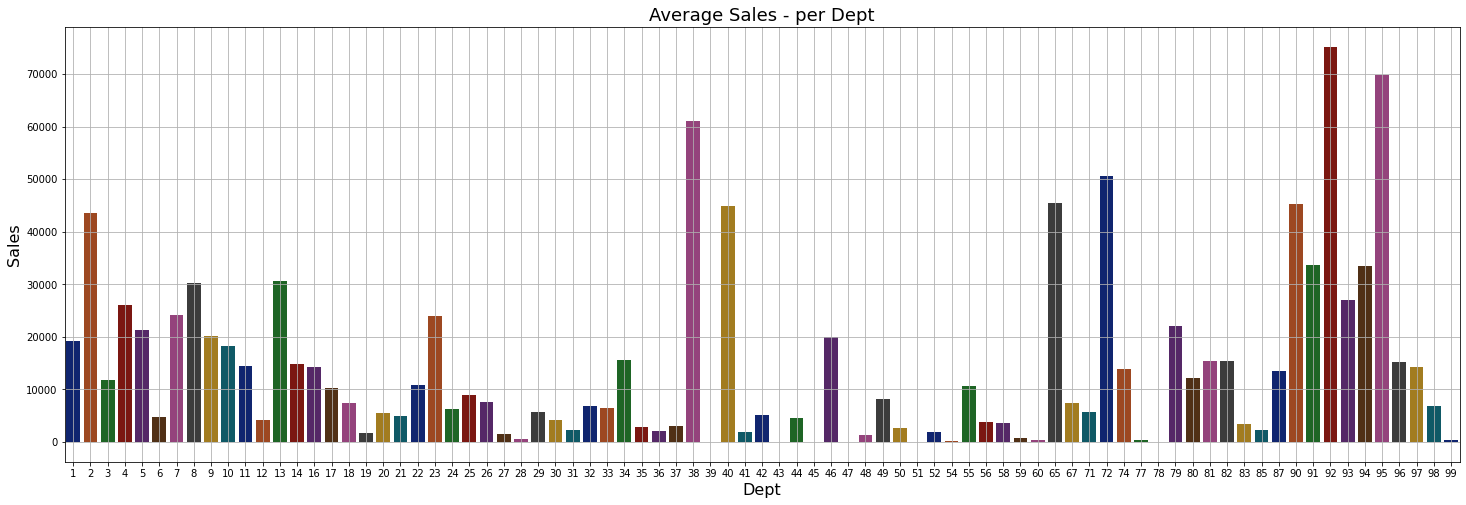

In [194]:
weekly_sales_dept = df_train['Weekly_Sales'].groupby(df_train['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales_dept.index, weekly_sales_dept.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

The graph above confirms also there are departments that sell much more than others.

Moreover, we can see there are missing depts such as the dept '15' and between 61 and 64.

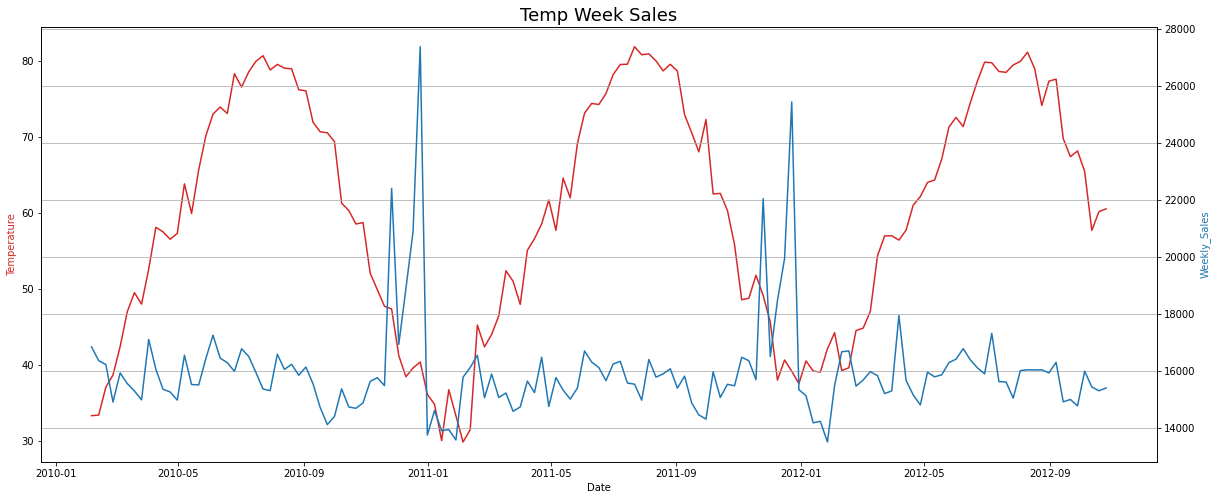

In [233]:
temp_weeksales = pd.merge(df_train['Temperature'].groupby(df_train['Date']).mean(),
         df_train['Weekly_Sales'].groupby(df_train['Date']).mean(),
         on='Date')
fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:red'
ax1.plot(temp_weeksales.index, temp_weeksales.Temperature, color=color)
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature', color=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(temp_weeksales.index, temp_weeksales.Weekly_Sales, color=color)
ax2.set_xlabel('Date')
ax2.set_ylabel('Weekly_Sales', color=color)
plt.grid()
plt.title('Temp Week Sales', fontsize=18)
plt.show()

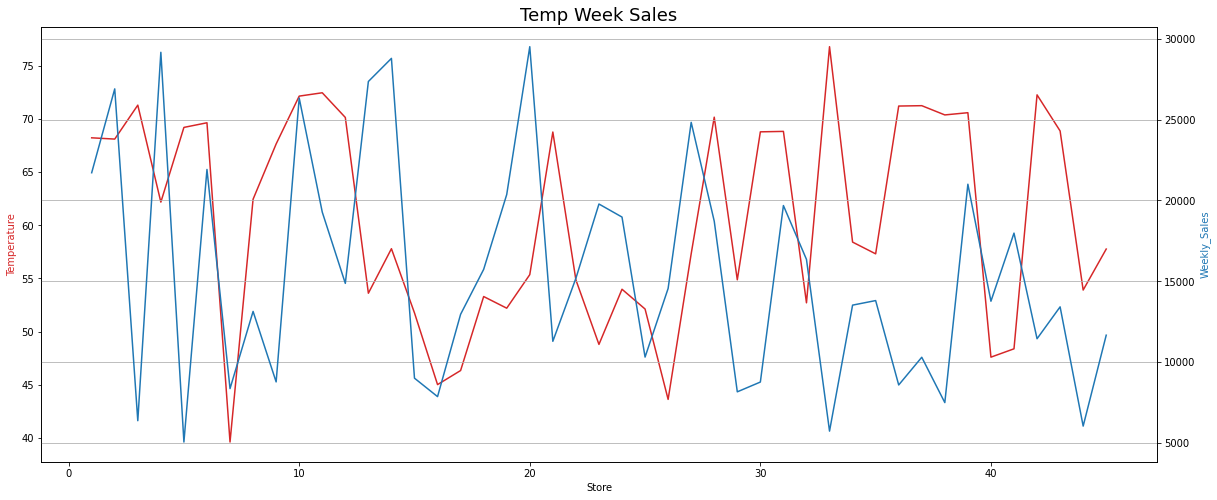

In [235]:
temp_weeksales_store = pd.merge(df_train['Temperature'].groupby(df_train['Store']).mean(),
         df_train['Weekly_Sales'].groupby(df_train['Store']).mean(),
         on='Store')
fig, ax1 = plt.subplots(figsize=(20,8))
color = 'tab:red'
ax1.plot(temp_weeksales_store.index, temp_weeksales_store.Temperature, color=color)
ax1.set_xlabel('Store')
ax1.set_ylabel('Temperature', color=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.plot(temp_weeksales.index, temp_weeksales.Weekly_Sales, color=color)
ax2.set_xlabel('Store')
ax2.set_ylabel('Weekly_Sales', color=color)
plt.grid()
plt.title('Temp Week Sales', fontsize=18)
plt.show()

In [229]:
temp_weeksales.head()

,Temperature,Weekly_Sales
Date,,
2010-02-05,33.277942,16836.121997
2010-02-12,33.361810,16352.056032
2010-02-19,37.038310,16216.658979
2010-02-26,38.629563,14899.549688
2010-03-05,42.373998,15921.015727


In [226]:
df_train.groupby(['Store','Date'])['Weekly_Sales'].mean()

Store  Date      
1      2010-02-05    22516.313699
       2010-02-12    22804.964444
       2010-02-19    22081.755753
       2010-02-26    19579.549861
       2010-03-05    21298.721644
                         ...     
45     2012-09-28    10805.665909
       2012-10-05    10786.103971
       2012-10-12    11128.247879
       2012-10-19    10880.689848
       2012-10-26    11347.484030
Name: Weekly_Sales, Length: 6435, dtype: float64

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

### We drop the 'Markdoewns' columns, after we will try to subsitute the Nan values with the mean or median

In [60]:
# drop columns of Nan (Markdowns)
df_train.dropna(axis='columns', inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  object 
 10  Size          421570 non-null  int64  
dtypes: bool(1), float64(5), int64(3), object(2)
memory usage: 35.8+ MB


In [66]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315


In [70]:
df_train['Week'] = df_train.Date.dt.week 
df_train['Year'] = df_train.Date.dt.year
df_train.head(100)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,5,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,A,151315,5,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,A,151315,5,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,A,151315,5,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,A,151315,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,24,2010-02-12,8050.24,True,38.51,2.548,211.242170,8.106,A,151315,6,2010
96,1,25,2010-02-12,13268.75,True,38.51,2.548,211.242170,8.106,A,151315,6,2010
97,1,26,2010-02-12,10050.92,True,38.51,2.548,211.242170,8.106,A,151315,6,2010
98,1,27,2010-02-12,2339.50,True,38.51,2.548,211.242170,8.106,A,151315,6,2010
